In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Loading a pretrained model

In [4]:
pipe_name='google/ddpm-celebahq-256'
img_pipe=DDPMPipeline.from_pretrained(pipe_name)
img_pipe.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/phong/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/phong/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

Sampling with DDIM

In [5]:
scheduler=DDIMScheduler.from_pretrained(pipe_name)
scheduler.set_timesteps(num_inference_steps=40)
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

In [ ]:
#Parameters
img_size=256
batch_size=4

Generate the images

40it [00:12,  3.25it/s]


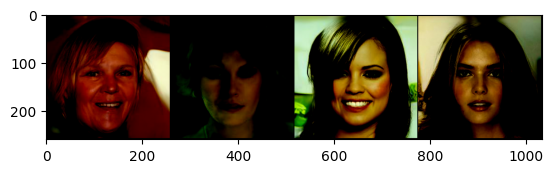

In [10]:
imgs=torch.randn(batch_size,3, img_size, img_size).to(device)
for i,t in tqdm(enumerate(scheduler.timesteps)):
    input=scheduler.scale_model_input(imgs,t)
    with torch.no_grad():
        noise_pred=img_pipe.unet(input,t)['sample']
    out_step=scheduler.step(noise_pred,t,imgs)
    imgs=out_step.prev_sample
grid=torchvision.utils.make_grid(out_step.prev_sample, nrow=4)
plt.imshow(grid.permute(1,2,0).cpu().clip(0,1)) 


In [9]:
out_step.keys()

odict_keys(['prev_sample', 'pred_original_sample'])

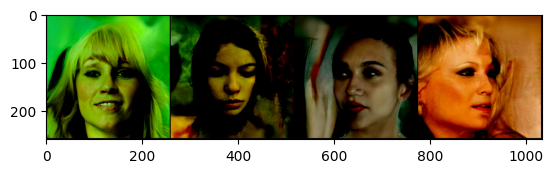

In [10]:
grid2=torchvision.utils.make_grid(out_step.pred_original_sample, nrow=4)
plt.imshow(grid2.permute(1,2,0).cpu().clip(0,1)) 


Dataset

In [8]:
dts_name="huggan/smithsonian_butterflies_subset"
data=load_dataset(dts_name, split='train')
data

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

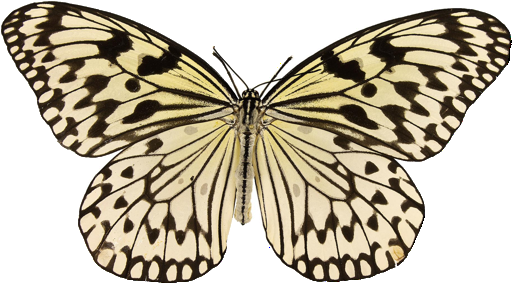

In [12]:
data[0]['image']

Data processing

In [ ]:
from torch.utils.data import DataLoader

In [9]:
transform=transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    #transforms.Normalize([0.5], [0.5])
])

In [10]:
def preprocess(dts):
    images=[transform(img.convert('RGB')) for img in dts['image']]
    return {'images': images}
data.set_transform(preprocess)
data

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

In [11]:
data[0]['images'].shape

torch.Size([3, 256, 256])

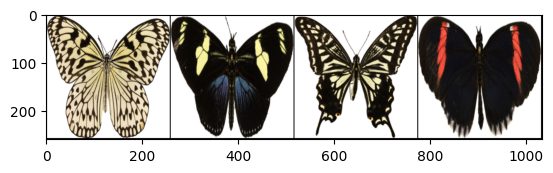

In [ ]:
data_loader=DataLoader(data, batch_size=batch_size)
batch=next(iter(data_loader))
grid=torchvision.utils.make_grid(batch['images'], nrow=4)
plt.imshow(grid.permute(1,2,0).cpu().clip(0,1))

Scheluder configs

In [16]:
img_pipe.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [17]:
T=img_pipe.scheduler.num_train_timesteps
T

/home/ntphong/miniconda3/envs/mlenv/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


1000

Fine Tuning

In [18]:
opt=torch.optim.AdamW(img_pipe.unet.parameters(), lr=1e-5)
criterion=nn.MSELoss()

In [19]:
n_epochs=11
losses=[]
for epoch in range(n_epochs):
    Loss=0
    for i, batch in tqdm(enumerate(data_loader)):
        opt.zero_grad()
        img_input=batch['images'].to(device)
        #sample noise
        noise=torch.randn(img_input.shape).to(device)
        bs=img_input.shape[0]        
        #timesteps
        ts=torch.randint(0, T, (bs,), device=device).long()
        #adding noise
        img_noise=img_pipe.scheduler.add_noise(img_input, noise, ts)
        #prediction  
        noise_pred=img_pipe.unet(img_noise, ts, return_dict=False)[0]
        #loss
        #loss=F.mse_loss(noise_pred, noise)
        loss=criterion(noise_pred, noise)
        #backward
        loss.backward()
        opt.step()
        losses.append(loss.item())
        Loss+=loss
    if epoch%2==0:
        print(f'Epoch: {epoch}, Loss: {Loss/len(data_loader)}')

250it [03:58,  1.05it/s]


Epoch: 0, Loss: 0.008747528307139874


250it [03:59,  1.04it/s]
250it [04:01,  1.04it/s]


Epoch: 2, Loss: 0.007007741369307041


250it [03:58,  1.05it/s]
250it [04:00,  1.04it/s]


Epoch: 4, Loss: 0.006019423250108957


250it [04:00,  1.04it/s]
250it [04:00,  1.04it/s]


Epoch: 6, Loss: 0.007927155122160912


250it [04:01,  1.03it/s]
250it [04:01,  1.03it/s]


Epoch: 8, Loss: 0.006275321822613478


250it [04:00,  1.04it/s]
250it [03:58,  1.05it/s]

Epoch: 10, Loss: 0.006525729317218065


Generate the sample

0it [00:00, ?it/s]

40it [00:12,  3.33it/s]


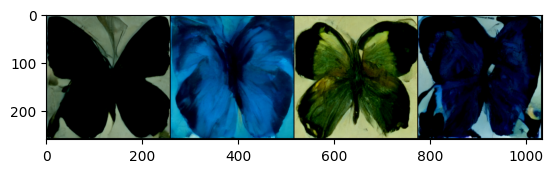

In [20]:
test=torch.randn(batch_size,3,img_size,img_size).to(device)
for i,t in tqdm(enumerate(scheduler.timesteps)):
    input=scheduler.scale_model_input(test,t)
    with torch.no_grad():
        noise_pred=img_pipe.unet(input,t)['sample']
    out_put=scheduler.step(noise_pred,t,test)
    test=out_put.prev_sample
grid=torchvision.utils.make_grid(test, nrow=4)
plt.imshow(grid.permute(1,2,0).cpu().clip(0,1)) 


In [29]:
out_put.keys()

odict_keys(['prev_sample', 'pred_original_sample'])

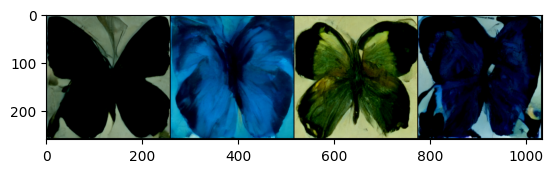

In [21]:
grid=torchvision.utils.make_grid(out_put['pred_original_sample'], nrow=4)
plt.imshow(grid.permute(1,2,0).cpu().clip(0,1)) 

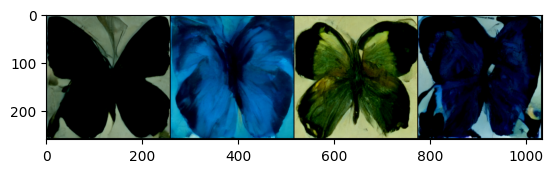

In [22]:
grid=torchvision.utils.make_grid(out_put['prev_sample'], nrow=4)
plt.imshow(grid.permute(1,2,0).cpu().clip(0,1)) 

Save model

In [23]:
img_pipe.save_pretrained('./diffusion_ft')